In [1]:
!ls

'Data Preprocessing.ipynb'   supermarkets_cleaned.csv
'Data Scrapper.ipynb'	     supermarkets_cleaned_with_popn.csv
 Model.ipynb		     tempmodel.h5


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
from matplotlib import pyplot as plt
from pykeops.torch import LazyTensor
from sklearn.cluster import KMeans

[pyKeOps]: Warning, cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [3]:
#Read Data, Drop unnecessary column and change - in rating to -1
supermarkets = pd.read_csv('supermarkets_cleaned_with_popn.csv')
supermarkets.drop('Unnamed: 0', axis=1, inplace=True)
supermarkets.loc[supermarkets['rating']=='-', 'rating'] = -1
supermarkets.loc[supermarkets['rating']=='0.0', 'rating'] = -1
supermarkets.rating = supermarkets.rating.map(float)
supermarkets.head()


,business_status,name,latitude,longitude,rating,atms,banks,bus_stations,churches,gas_stations,hospitals,mosques,pharmacies,restaurants,schools,train_stations,Males,Females
0,OPERATIONAL,"AllMart Plus, Ayat Neighborhood, Addis Ababa",9.020171,38.875108,-1.0,1,9,0,7,3,3,0,2,28,4,0,145225,163770
1,OPERATIONAL,Nahuta SuperMarket,9.022502,38.785852,5.0,8,36,0,15,1,18,4,9,105,28,0,161592,185072
2,OPERATIONAL,Afran Mini Market,9.057363,38.724341,-1.0,0,15,0,9,2,2,9,6,54,20,0,129396,138228
3,OPERATIONAL,251 Store ET Gerji store,9.001777,38.810458,-1.0,1,27,0,11,1,6,0,13,153,27,0,145225,163770
4,OPERATIONAL,Selam Super Market,9.011199,38.796551,-1.0,1,34,0,22,6,18,1,9,110,21,0,145225,163770


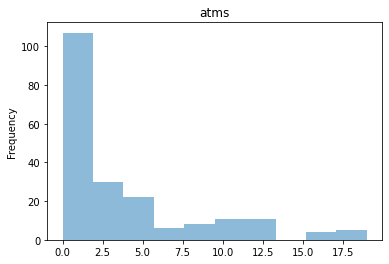

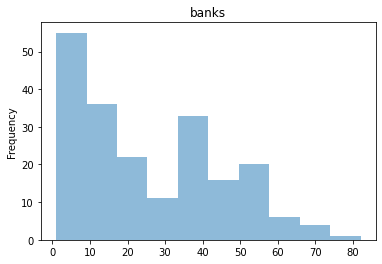

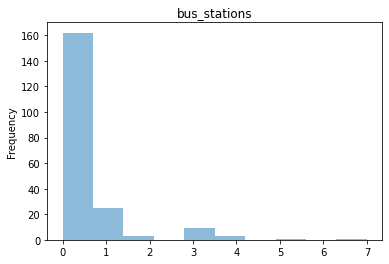

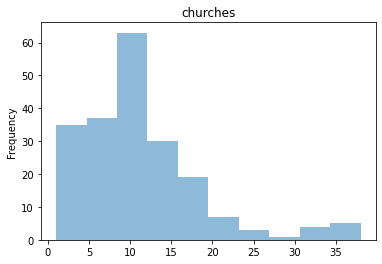

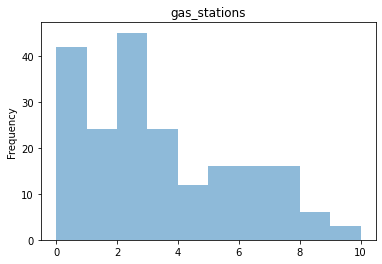

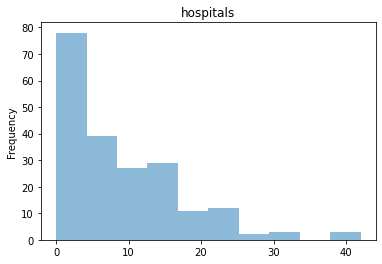

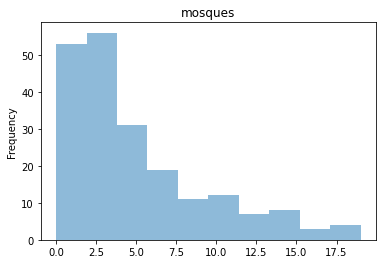

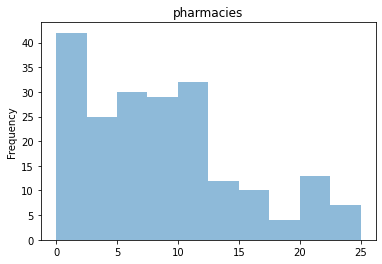

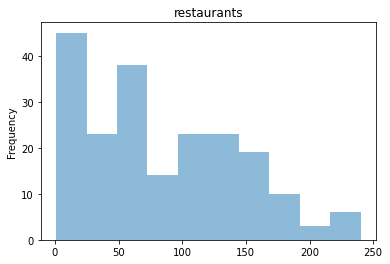

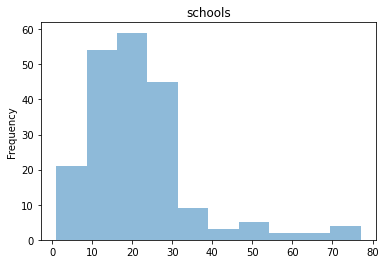

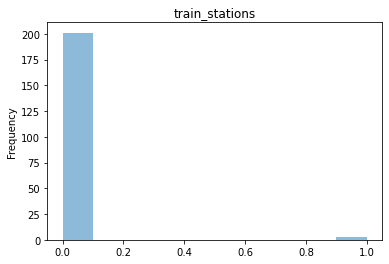

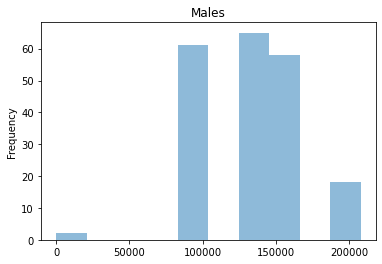

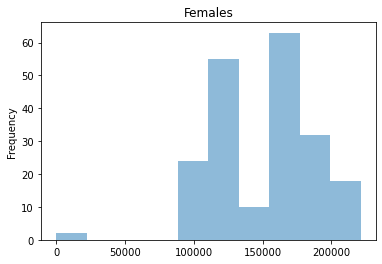

In [4]:
#Plot histogram to show distribution of features among the highest ranked supermarkets
columns = supermarkets.columns
rating_highest = supermarkets[supermarkets['rating']==5.0]
for col in columns:
    if col not in {'rating', 'business_status', 'name', 'latitude', 'longitude'}:
        rating_highest[col].plot.hist(bins = 10, alpha=0.5,title = col)
        plt.show()

In [5]:
#Try Kmeans to fill out the missing values
km = KMeans(n_clusters=6)
x = supermarkets.drop(['rating', 'business_status', 'name', 'latitude', 'longitude'],axis=1).values
yp = km.fit_predict(x)
supermarkets['predicted_rating'] = yp
supermarkets[['rating', 'predicted_rating']].head(30)

,rating,predicted_rating
0,-1.0,2
1,5.0,3
2,-1.0,5
3,-1.0,2
4,-1.0,2
5,-1.0,0
6,-1.0,5
7,-1.0,0
8,-1.0,2
9,-1.0,0


In [6]:
supermarkets.loc[supermarkets['rating']==-1.0, 'rating'] = np.random.choice([1.0,2.0,3.0,4.0,5.0])
supermarkets['rating'] = np.around(supermarkets['rating'].astype(np.float))
supermarkets['rating'] = supermarkets['rating'].map(int)
supermarkets['rating'].value_counts()

4    1063
5     228
3      59
1      22
2      16
Name: rating, dtype: int64

In [7]:
from sklearn.model_selection import train_test_split

X = supermarkets.drop(['business_status','name','latitude','longitude', 'rating', 'predicted_rating'], axis=1).values
y = supermarkets['rating'].values

X, y = torch.tensor(X), torch.tensor(y)

In [8]:
def one_hot_encode(vector):
    n_classes = len(vector.unique())
    one_hot = torch.zeros((vector.shape[0], n_classes)).type(torch.LongTensor)
    vector_type = vector.type(torch.LongTensor).unsqueeze(1)
    return one_hot.scatter(0, vector_type, 1)
y_one_hot = one_hot_encode(y)

In [9]:
# random_indices = torch.randperm(X.shape[0])

n_train = int(0.8 * X.shape[0])

X_train = X[:n_train]
X_test = X[n_train:]

y_train = y[:n_train]
y_test = y[n_train:]

y_train_one_hot = y_one_hot[:n_train]
y_test_one_hot = y_one_hot[n_train:]

In [10]:
model = torch.nn.Sequential(
    torch.nn.Linear(13, 6),
    # torch.nn.Linear(120, 5)
)

In [11]:
learning_rate = 0.05
lambda_param = 0.01
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=lambda_param
)

In [12]:
loss_function = torch.nn.CrossEntropyLoss()

In [13]:
n_iterations = 5000
for i in range(1, n_iterations + 1):
    Z = model(X_train.float())
    loss = loss_function(Z, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i == 1 or i % 50 == 0:
        print("Loss at iteration {}: {}".format(i, loss))

test_predictions = torch.argmax(
    torch.softmax(model(X_test.float()), 1), axis=1
)
test_accuracy = float(sum(test_predictions == y_test)) / y_test.shape[0]
print("\nFinal Test Accuracy: {}".format(test_accuracy))

Loss at iteration 1: 66543.6484375
Loss at iteration 50: 579803392.0
Loss at iteration 100: 529958592.0
Loss at iteration 150: 433239648.0
Loss at iteration 200: 372839520.0
Loss at iteration 250: 322630176.0
Loss at iteration 300: 225758288.0
Loss at iteration 350: 175659360.0
Loss at iteration 400: 543043136.0
Loss at iteration 450: 493652736.0
Loss at iteration 500: 397154880.0
Loss at iteration 550: 337283392.0
Loss at iteration 600: 286725280.0
Loss at iteration 650: 190184016.0
Loss at iteration 700: 140249024.0
Loss at iteration 750: 565064384.0
Loss at iteration 800: 504956768.0
Loss at iteration 850: 351593376.0
Loss at iteration 900: 357901152.0
Loss at iteration 950: 307805792.0
Loss at iteration 1000: 210989360.0
Loss at iteration 1050: 122694408.0
Loss at iteration 1100: 73308960.0
Loss at iteration 1150: 487451712.0
Loss at iteration 1200: 231705664.0
Loss at iteration 1250: 135481680.0
Loss at iteration 1300: 124180016.0
Loss at iteration 1350: 311396576.0
Loss at iterat

In [14]:
torch.save(model, 'tempmodel.h5')

In [48]:
l = torch.load('tempmodel.h5')
test_values = torch.tensor([[15.0,41.0,85.0,70.0,36.0,30.0,15.0,20.0,16.0,40.0,20.0,15000,15000]])
torch.argmax(
torch.softmax(l(test_values), 1)
    , axis=1
)

tensor([4])